### Import library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
import datetime
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
## Import data
df_movies=pd.read_csv("./netflix_titles.csv")
df_movies.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


### Data preparation

In [3]:
n_rows,n_cols=df_movies.shape
print(f'The dataframe has {n_rows} rows and {n_cols} columns.')

The dataframe has 6234 rows and 12 columns.


Check if show_ids are unique to one another 

In [4]:
assert(len(df_movies['show_id'].unique())==n_rows)

Check if column data types are consistent

In [5]:
def col_dtype(s):
    
    dtypes = set(s.apply(type))
    
    return dtypes

for col in df_movies.columns:
    print("Data type of column %15s: %s" % (col, col_dtype(df_movies[col])))

Data type of column         show_id: {<class 'int'>}
Data type of column            type: {<class 'str'>}
Data type of column           title: {<class 'str'>}
Data type of column        director: {<class 'str'>, <class 'float'>}
Data type of column            cast: {<class 'str'>, <class 'float'>}
Data type of column         country: {<class 'str'>, <class 'float'>}
Data type of column      date_added: {<class 'str'>, <class 'float'>}
Data type of column    release_year: {<class 'int'>}
Data type of column          rating: {<class 'str'>, <class 'float'>}
Data type of column        duration: {<class 'str'>}
Data type of column       listed_in: {<class 'str'>}
Data type of column     description: {<class 'str'>}


Comments about shown column data types:<br>

<li><code>country</code> and <code>rating</code> columns are in both <code>str</code> and <code>float</code> type, to unify into <code>str</code>
<li><code>date_added</code> are in both <code>str</code> and <code>float</code> type, but will convert into <code>datetime</code>
<li><code>director</code> and <code>cast</code> are also in <code>str</code> and <code>float</code> I will convert into <code>str</code> and then <code>array</code> since they contain different combined values<br>
<li><code>listed in</code> is in <code>str</code> but its values are combined, to convert into <code>array</code>
<li><code>duration</code> is <code>str</code> but it is a measurement
<li>Most likely <code>float</code> values in category columns such as <code>director</code> <code>cast</code> <code>country</code> etc is caused by <code>nan</code>


### Handle column Title

Column Title data are in the format of <code>(Movie name):(Episode)</code>. I will process to split them into prefix and postfix

In [6]:
df_movies['title_prefix']=df_movies['title'].apply(lambda x:x[:x.find(":")] if x.find(":")>=0 else x)
df_movies['title_postfix']=df_movies['title'].apply(lambda x:x[x.find(":")+1:] if x.find(":")>=0 else np.nan)

##Check for title_prefix values
df_movies.title_prefix.value_counts().sort_values(ascending=False)

NOVA                        19
Monster High                12
Trailer Park Boys            9
ReMastered                   8
Krish Trish and Baltiboy     8
                            ..
Sacred Games                 1
Caught on Camera             1
The 100                      1
Age of Glory                 1
Friends                      1
Name: title_prefix, Length: 5854, dtype: int64

### Handle column Director

Column Director data contain values seperated by comma <code>,</code>. To transform into array

In [7]:
df_movies['director']=df_movies['director'].apply(lambda x:str(x).split(", "))
df_movies['director'].head()

0    [Richard Finn, Tim Maltby]
1                         [nan]
2                         [nan]
3                         [nan]
4            [Fernando Lebrija]
Name: director, dtype: object

For movies that are without Director info, replace <code>nan</code> with <code>Null</code> array

In [8]:
df_movies['director']=df_movies['director'].apply(lambda x:[] if str(x)=="['nan']" else x)
df_movies['director'].head()

0    [Richard Finn, Tim Maltby]
1                            []
2                            []
3                            []
4            [Fernando Lebrija]
Name: director, dtype: object

### Handle column Cast

Similar to column Director, however column Cast data seperated by a comma and a space <code>, </code>

In [9]:
df_movies['cast'].head()

0    Alan Marriott, Andrew Toth, Brian Dobson, Cole...
1                                     Jandino Asporaat
2    Peter Cullen, Sumalee Montano, Frank Welker, J...
3    Will Friedle, Darren Criss, Constance Zimmer, ...
4    Nesta Cooper, Kate Walsh, John Michael Higgins...
Name: cast, dtype: object

In [10]:
df_movies['cast']=df_movies['cast'].apply(lambda x:str(x).split(", "))

#replace nan with Null array
df_movies['cast']=df_movies['cast'].apply(lambda x:[] if str(x)=="['nan']" else x)
df_movies['cast'].head()

0    [Alan Marriott, Andrew Toth, Brian Dobson, Col...
1                                   [Jandino Asporaat]
2    [Peter Cullen, Sumalee Montano, Frank Welker, ...
3    [Will Friedle, Darren Criss, Constance Zimmer,...
4    [Nesta Cooper, Kate Walsh, John Michael Higgin...
Name: cast, dtype: object

### Handle column Duration

Column Duration data has 2 format type, that is either season or minutes, these could belong to 2 types that is TV show and movie.<br>
I will test this out by compare numbers of movie types and duration type



In [11]:
#Count of Types: Movie and TV Show
df_movies['type'].value_counts()

Movie      4265
TV Show    1969
Name: type, dtype: int64

In [12]:
#Count of data contain 'min' in column Duration
df_movies['duration'].str.contains('min', na=False).value_counts()

True     4265
False    1969
Name: duration, dtype: int64

Doing the same for <code>season</code> also receive similar result, so we can conclude our theory <br>
Since the <code>duration</code> data format is not consistent, we will split into 2 columns that are <code>season</code> into season number, and <code>min</code> into minute number. Only the value will be kept<br>
This will help with other upcoming calculation and sorting

In [13]:
##Create 'min' and 'season' columns, then remove time unit
df_movies['min']=df_movies['duration'][df_movies['duration'].apply(lambda x:x.find("min")>=0)]
df_movies['min']=pd.to_numeric(df_movies['min'].apply(lambda x:x[:-4] if pd.notnull(x) else np.nan), errors='coerce').convert_dtypes() 

df_movies['season']=df_movies['duration'][df_movies['duration'].apply(lambda x:x.find("Season")>=0)]
df_movies['season']=pd.to_numeric(df_movies['season'].apply(lambda x:x.replace('Seasons','').replace('Season','') if pd.notnull(x) else np.nan).convert_dtypes(), errors='coerce').convert_dtypes() 

### Handle column Listed_in

Convert the column into arrays, then list out movie cateogory

In [14]:
df_movies['listed_in_array']=df_movies['listed_in'].apply(lambda x:str(x).split(", "))
df_movies['listed_in_array'].head()

0    [Children & Family Movies, Comedies]
1                       [Stand-Up Comedy]
2                              [Kids' TV]
3                              [Kids' TV]
4                              [Comedies]
Name: listed_in_array, dtype: object

In [15]:
np.unique(df_movies['listed_in_array'].sum())

array(['Action & Adventure', 'Anime Features', 'Anime Series',
       'British TV Shows', 'Children & Family Movies',
       'Classic & Cult TV', 'Classic Movies', 'Comedies',
       'Crime TV Shows', 'Cult Movies', 'Documentaries', 'Docuseries',
       'Dramas', 'Faith & Spirituality', 'Horror Movies',
       'Independent Movies', 'International Movies',
       'International TV Shows', "Kids' TV", 'Korean TV Shows',
       'LGBTQ Movies', 'Movies', 'Music & Musicals', 'Reality TV',
       'Romantic Movies', 'Romantic TV Shows', 'Sci-Fi & Fantasy',
       'Science & Nature TV', 'Spanish-Language TV Shows',
       'Sports Movies', 'Stand-Up Comedy', 'Stand-Up Comedy & Talk Shows',
       'TV Action & Adventure', 'TV Comedies', 'TV Dramas', 'TV Horror',
       'TV Mysteries', 'TV Sci-Fi & Fantasy', 'TV Shows', 'TV Thrillers',
       'Teen TV Shows', 'Thrillers'], dtype='<U28')

There are similar categories such as <code>Comedies</code> and <code>TV Comedies</code>, <code>Classic & Cult TV</code> and  <code>Classic Movies'/'Cult Movies</code>.<br>
This could be of different movie types, as for <code>Movie</code> and <code>TV Show</code>

In [16]:
##Check if every category with 'TV' is actually 'TV Show' type
df_movies['listed_in'].str.contains('TV', na=False).value_counts()

False    4341
True     1893
Name: listed_in, dtype: int64

In [17]:
print('There are',len(df_movies[df_movies['type']=='TV Show']), 'TV Shows')

There are 1969 TV Shows


In [18]:
##Check if any type that is not 'TV Show' is listed in 'TV'
m=df_movies[df_movies['type']!='TV Show']
sum(m['listed_in_array'].apply(lambda l:any(x.find("TV")>=0 for x in l)))

0

So it is safe to say that all movies listed as <code>TV</code> in their categories are actually <code>TV Shows</code>. <br>
Now we can remove the <code>TV</code> in <code>listed_in</code> to simplify categories in those that has similar names, yet still able to know if one movie is series or not

In [19]:
#Array of category with 'TV' in it
TV_listed=[a for a in np.unique(df_movies['listed_in_array'].sum()) if a.find("TV")>=0]

#Array of category with 'TV' in it that are removed 'TV'
TV_listed_remove=[a.replace("TV ","").replace("TV","") for a in TV_listed]

#Array of category without 'TV'
TV_listed_noTV=[a for a in np.unique(df_movies['listed_in_array'].sum()) if a.find("TV")==-1]

#List out category names that can replace
to_replace_list=list(set(TV_listed_remove).intersection(TV_listed_noTV))
to_replace_list

['Action & Adventure', 'Sci-Fi & Fantasy', 'Dramas', 'Comedies', 'Thrillers']

In [20]:
##Category to replace
to_replace=[TV_listed[i] for i in [item[0] for item in enumerate(TV_listed_remove) if item[1] in to_replace_list]]

to_replace

['TV Action & Adventure',
 'TV Comedies',
 'TV Dramas',
 'TV Sci-Fi & Fantasy',
 'TV Thrillers']

In [21]:
##Create dict to map to replace categories with to be replaced categories
replace_dict=dict((el,el.replace("TV ","")) for el in to_replace)
replace_dict

{'TV Action & Adventure': 'Action & Adventure',
 'TV Comedies': 'Comedies',
 'TV Dramas': 'Dramas',
 'TV Sci-Fi & Fantasy': 'Sci-Fi & Fantasy',
 'TV Thrillers': 'Thrillers'}

In [22]:
##5 listed categories with 'TV' will be replaced with existed category names
df_movies['listed_in_array']=df_movies['listed_in_array'].apply(lambda x:[replace_dict.get(i,i) for i in x])
np.unique(df_movies['listed_in_array'].sum())

array(['Action & Adventure', 'Anime Features', 'Anime Series',
       'British TV Shows', 'Children & Family Movies',
       'Classic & Cult TV', 'Classic Movies', 'Comedies',
       'Crime TV Shows', 'Cult Movies', 'Documentaries', 'Docuseries',
       'Dramas', 'Faith & Spirituality', 'Horror Movies',
       'Independent Movies', 'International Movies',
       'International TV Shows', "Kids' TV", 'Korean TV Shows',
       'LGBTQ Movies', 'Movies', 'Music & Musicals', 'Reality TV',
       'Romantic Movies', 'Romantic TV Shows', 'Sci-Fi & Fantasy',
       'Science & Nature TV', 'Spanish-Language TV Shows',
       'Sports Movies', 'Stand-Up Comedy', 'Stand-Up Comedy & Talk Shows',
       'TV Horror', 'TV Mysteries', 'TV Shows', 'Teen TV Shows',
       'Thrillers'], dtype='<U28')

### Handle column Country

In [23]:
df_movies['country'].value_counts()

United States                                    2032
India                                             777
United Kingdom                                    348
Japan                                             176
Canada                                            141
                                                 ... 
India, Japan                                        1
Norway, Germany, Sweden                             1
United Kingdom, Canada, France, United States       1
United Arab Emirates, Jordan                        1
Cyprus, Austria, Thailand                           1
Name: country, Length: 554, dtype: int64

In [24]:
##Convert into array 
df_movies['country']=df_movies['country'].apply(lambda x:str(x).split(", "))

##Replace nan with Null array
df_movies['country']=df_movies['country'].apply(lambda x:[] if str(x)=="['nan']" else x)
df_movies['country'].head()

0    [United States, India, South Korea, China]
1                              [United Kingdom]
2                               [United States]
3                               [United States]
4                               [United States]
Name: country, dtype: object

### Handle column Date_add

In [25]:
df_movies['date_added']=pd.to_datetime(df_movies['date_added'])
df_movies['date_added']

0      2019-09-09
1      2016-09-09
2      2018-09-08
3      2018-09-08
4      2017-09-08
          ...    
6229          NaT
6230          NaT
6231          NaT
6232          NaT
6233          NaT
Name: date_added, Length: 6234, dtype: datetime64[ns]

### Handle column Date_add

Conver Date_add data type into <code>datetime</code>

In [26]:
df_movies['date_added']=pd.to_datetime(df_movies['date_added'])
df_movies['date_added']

0      2019-09-09
1      2016-09-09
2      2018-09-08
3      2018-09-08
4      2017-09-08
          ...    
6229          NaT
6230          NaT
6231          NaT
6232          NaT
6233          NaT
Name: date_added, Length: 6234, dtype: datetime64[ns]

### Handle missing values

We will cross check missing values to see if it is feasible to replace with another value. However I will leave missing values in columns such as <code>director</code>,<code>cast</code>,<code>country</code> as it is, due to it will create bias if create another label for this.<br>
The 2 columns seem find to be filled is <code>date_added</code> and <code>rating</code>

In [27]:
##Fill missing rating with its mode value.
df_movies['rating']=df_movies['rating'].fillna(df_movies['rating'].mode()[0])

In [28]:
##Fill missing date_add with avg year from release_year to date_added
##Set day and month to 1/1
df_movies.loc[df_movies['date_added'].isnull(),'release_year'].apply(lambda x:datetime.datetime(x+int((df_movies['date_added'].dt.year-df_movies['release_year']).median()),1,1))

6223   2009-01-01
6224   2019-01-01
6225   2004-01-01
6226   2013-01-01
6227   2016-01-01
6228   2011-01-01
6229   2016-01-01
6230   2017-01-01
6231   2017-01-01
6232   2014-01-01
6233   2004-01-01
Name: release_year, dtype: datetime64[ns]

### Data cleaning

#### Check for the correlation between <code>date_added</code> and <code>release_year</code>

In [29]:
nume_col_profiles_df = df_movies.loc[:,['release_year', 'date_added']] \
                                 .agg([lambda x: pd.Series.describe(x, datetime_is_numeric=True)])

nume_col_profiles_df.columns = ['release_year', 'date_added']

nume_col_profiles_df

,release_year,date_added
count,6234.00000,6223
mean,2013.35932,2018-07-01 15:36:42.346135296
std,8.81162,NaN
min,1925.00000,2008-01-01 00:00:00
25%,2013.00000,2017-10-01 00:00:00
50%,2016.00000,2018-09-30 00:00:00
75%,2018.00000,2019-06-08 00:00:00
max,2020.00000,2020-01-18 00:00:00


In [30]:
df_movies.loc[:,['release_year', 'date_added']].agg([lambda x: pd.Series.describe(x, datetime_is_numeric=True)]).set_axis(['release_year', 'date_added'], axis=1)

,release_year,date_added
count,6234.00000,6223
mean,2013.35932,2018-07-01 15:36:42.346135296
std,8.81162,NaN
min,1925.00000,2008-01-01 00:00:00
25%,2013.00000,2017-10-01 00:00:00
50%,2016.00000,2018-09-30 00:00:00
75%,2018.00000,2019-06-08 00:00:00
max,2020.00000,2020-01-18 00:00:00


We can have some observation as below <br>
Netflix added movie(s) released in 1925, it was around the time the first movie was released - 1895. This one is a really old movie(s)<br>
Maximum release_year is 2020, so probably this dataset is just updated till around 2020<br>
Release period span 1925 to 2016 seems to not have lots of movies released although it was a long time range. The film industry was having a lot more within just a short time from 2016 to 2020<br>

Logically, movies should have its <code>date_added</code> later than its <code>release_year</code>. However, we will check to see if it is true

In [31]:
df_movies.loc[df_movies['date_added'].dt.year < df_movies['release_year'],['type','title','date_added','release_year']]

,type,title,date_added,release_year
518,Movie,Incoming,2018-10-26,2019
1315,TV Show,Maradona in Mexico,2019-11-13,2020
2028,TV Show,Jack Taylor,2013-03-31,2016
3144,Movie,Hans Teeuwen: Real Rancour,2017-07-01,2018
4587,TV Show,Tokyo Trial,2016-12-13,2017
4662,TV Show,Little Singham,2018-12-01,2019
5784,TV Show,Unbreakable Kimmy Schmidt,2018-05-30,2019
5789,TV Show,Arrested Development,2018-05-29,2019
6087,TV Show,Sense8,2016-12-23,2018


We see that, to <code>TV Show</code>, the date_added is usually 
These are a couple of movies that have <code>release_year</code> later than <code>dated_added</code>. These could be added on Netflix as premire before actual released date. However, there is no firm evident for these cases, so we will not touch it for now

#### Check for <code>director</code>

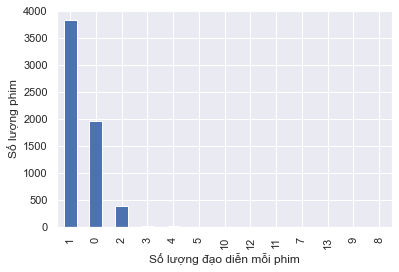

In [32]:
sns.set_theme()

ax = df_movies['director'].apply(lambda x:len(x)).value_counts().plot.bar()
ax.set(ylabel='Số lượng phim', xlabel='Số lượng đạo diễn mỗi phim')

plt.show()

Most movies just have 1 director. Quite many missing on director info, also the <code>0</code> value

In [33]:
##Top 10 director direct most movies
for country,times in Counter(df_movies['director'].sum()).most_common(10):
    print("%-20s %4.1d" % (country, times))

Jan Suter              21
Raúl Campos            19
Jay Karas              14
Marcus Raboy           14
Jay Chapman            12
Martin Scorsese         9
Steven Spielberg        9
Umesh Mehra             8
Shannon Hartman         8
Lance Bangs             8


In [34]:
##Director combo that direct most movies
df_movies['director'].apply(lambda x:str(x)).value_counts()

[]                                   1969
['Raúl Campos', 'Jan Suter']           18
['Marcus Raboy']                       14
['Jay Karas']                          13
['Jay Chapman']                        12
                                     ... 
['Ruel S. Bayani']                      1
['Peter Mortimer', 'Josh Lowell']       1
['Greg Coolidge']                       1
['Owen Egerton']                        1
['Onur Ünlü']                           1
Name: director, Length: 3302, dtype: int64

Raúl Campos and Jan Suter together made 18 movies, while seperately count, Suter made 21 and Campos made 19. We can tell they mostly work together<br>
So far no abnormal problem within <code>director</code> data

#### Check for <code>cast</code>

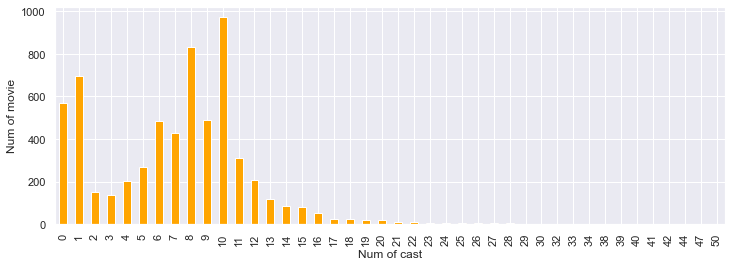

In [35]:
##Show number of casts per movie
z=df_movies['cast'].apply(lambda x:len(x)).value_counts()

ax = z.sort_index().plot.bar(figsize=(12,4),color='orange').set(ylabel='Num of movie', xlabel='Num of cast')

plt.show()

#### Check for <code>country</code>

In [36]:
##Top 10 countries produce the most movies
for country,times in Counter(df_movies['country'].sum()).most_common(10):
    print("%-15s %5d" % (country, times))

United States    2609
India             838
United Kingdom    601
Canada            318
France            271
Japan             231
Spain             178
South Korea       162
Germany           151
Mexico            129


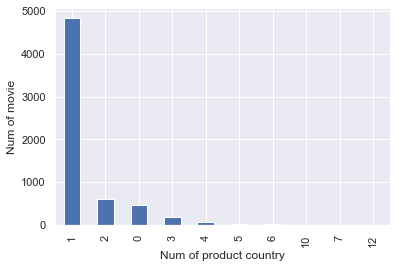

In [37]:
df_movies['country'].apply(lambda x:len(x)).value_counts().plot.bar().set(ylabel='Num of movie', xlabel='Num of product country')

plt.show()

The United States produced the most movies, and significant higher than the following country - Indian, by triple of it.<br>
Most movies was self-produced by a signle country. Exceptional case(s) was produced by 12 countries

#### Check for <code>duration</code>

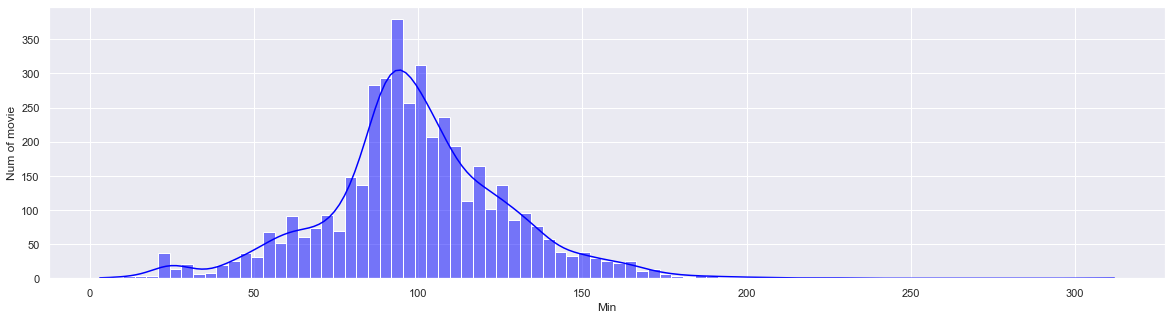

In [38]:
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
sns.histplot(x='min',data=df_movies, kde=True, color='blue')
ax.set_xlabel("Min")
ax.set_ylabel("Num of movie")
plt.show()

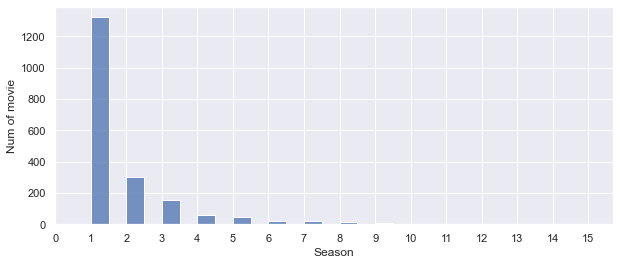

In [39]:
fig, ax = plt.subplots()
fig.set_size_inches(10,4)
sns.histplot(x='season',data=df_movies,binwidth=0.5)
ax.set_xlabel("Season")
ax.set_ylabel("Num of movie")
ax.set_xticks(range(len(df_movies['season'].unique())))

plt.show()

We can tell from the visualization of movies that most non-series have average length at ~90 mins. We will check on movies that have shortest and longest time to see if there are any inaccuracies

Most series movies have 1 season. We can tell that a series movie need a lot of factors in order to produce more seasons.

In [40]:
df_movies[(df_movies['min']==df_movies['min'].min())|(df_movies['min']==df_movies['min'].max())][['title','duration','listed_in','description','country']]

,title,duration,listed_in,description,country
2478,Silent,3 min,"Children & Family Movies, Sci-Fi & Fantasy","""Silent"" is an animated short film created by ...",[United States]
4315,Black Mirror: Bandersnatch,312 min,"Dramas, International Movies, Sci-Fi & Fantasy","In 1984, a young programmer begins to question...",[United States]


## Question I: To every movie a user searches for, what movie should we recommend along

Finding the answer to this question will be beneficial for both users and the movie service provider:    
<li><b>For users:</b> Users search for a movie to watch, and after watching, they may want to continue watching films of the same genre, with the same actors, from the same country, or by the same director. It would be convenient for users if the system could suggest a list of movies similar to the one they are searching for
<li><b>For the movie service provider:</b> If the system makes good recommendations, there's a high likelihood that users will continue watching the suggested films, leading to longer usage of the service and increased revenue for the provider.
    The recommendation system we build will be a simple one. When a user searches for a movie title, instead of returning only that specific movie, the system will suggest similar films. The similarity of movies will be defined by factors such as <code>title</code>, <code>cast</code>, <code>director</code>, <code>country</code>, <code>rating</code>, and <code>genre</code>.

Our hypothesis is that if a user searches for an American movie, it is likely that the user enjoys watching American films. If a user searches for a specific movie, we can suggest additional films with the same director or cast, among other factors. 

### Convert <code>title</code>, <code>cast</code>, <code>director</code>, <code>country</code>, <code>rating</code>, and <code>genre</code> to String type

We will apply get_dummies method on these columns and turn them into several bolean columns. For <code>cast</code>, due to it contains too many values, we will only pick top 3 labels presumably are the main casts 

In [41]:
##Create df_rec for the recommendation

##Retrieve top 3 casts
df_rec=df_movies.copy()
df_rec['cast_top_3']=df_rec['cast'].apply(lambda x:x[:3])

#Drop unused columns
df_rec.drop(columns=['cast','cast','listed_in','date_added','release_year','duration',
                     'title_postfix','show_id','min','season'],inplace=True)
df_rec.head()

,type,title,director,country,rating,description,title_prefix,listed_in_array,cast_top_3
0,Movie,Norm of the North: King Sized Adventure,"[Richard Finn, Tim Maltby]","[United States, India, South Korea, China]",TV-PG,Before planning an awesome wedding for his gra...,Norm of the North,"[Children & Family Movies, Comedies]","[Alan Marriott, Andrew Toth, Brian Dobson]"
1,Movie,Jandino: Whatever it Takes,[],[United Kingdom],TV-MA,Jandino Asporaat riffs on the challenges of ra...,Jandino,[Stand-Up Comedy],[Jandino Asporaat]
2,TV Show,Transformers Prime,[],[United States],TV-Y7-FV,"With the help of three human allies, the Autob...",Transformers Prime,[Kids' TV],"[Peter Cullen, Sumalee Montano, Frank Welker]"
3,TV Show,Transformers: Robots in Disguise,[],[United States],TV-Y7,When a prison ship crash unleashes hundreds of...,Transformers,[Kids' TV],"[Will Friedle, Darren Criss, Constance Zimmer]"
4,Movie,#realityhigh,[Fernando Lebrija],[United States],TV-14,When nerdy high schooler Dani finally attracts...,#realityhigh,[Comedies],"[Nesta Cooper, Kate Walsh, John Michael Higgins]"


In [42]:
df_rec['type']=df_rec['type'].replace({'TV Show':0,'Movie':1})

df_rec=df_rec.join(pd.get_dummies(df_rec['cast_top_3'].apply(pd.Series).stack(), prefix='cast').groupby(level=0).sum(), rsuffix='_dummy')
df_rec=df_rec.join(pd.get_dummies(df_rec['director'].apply(pd.Series).stack(), prefix='cast').groupby(level=0).sum(), rsuffix='_dummy')
df_rec=df_rec.join(pd.get_dummies(df_rec['country'].apply(pd.Series).stack(), prefix='cast').groupby(level=0).sum(), rsuffix='_dummy')
df_rec=df_rec.join(pd.get_dummies(df_rec['listed_in_array'].apply(pd.Series).stack(), prefix='cast').groupby(level=0).sum(), rsuffix='_dummy')
df_rec=df_rec.join(pd.get_dummies(df_rec['rating'].apply(pd.Series).stack(), prefix='cast').groupby(level=0).sum(), rsuffix='_dummy')

df_rec.drop(columns=['director','title','country','rating','description','title_prefix','cast_top_3','listed_in_array'],inplace=True)

### Fill NaN value with 0
df_rec=df_rec.fillna(0)

df_rec.head()

,type,cast_4Minute,cast_50 Cent,cast_A-ra Go,cast_A. Murat Özgen,cast_A.J. Cook,cast_A.J. LoCascio,cast_A.K. Hangal,cast_A.R. Rahman,cast_A.S. Sasi Kumar,...,cast_PG-13,cast_R,cast_TV-14,cast_TV-G,cast_TV-MA,cast_TV-PG,cast_TV-Y,cast_TV-Y7,cast_TV-Y7-FV,cast_UR
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0


Now there are only bolean columns left. We will process to do the recommendation

In [43]:
def suggest_movies(movie_title, num_suggestions=5):
    # Check if the movie title exists
    if movie_title not in df_movies['title'].values:
        print(f"Movie with title '{movie_title}' not found.")
        return
    # Get the row index of the movie with the given title
    movie_index = df_rec[df_movies['title'] == movie_title].index[0]

    # Calculate the cosine similarity between movies
    cosine_sim = cosine_similarity(df_rec)

    # Get the similarity scores for the given movie
    sim_scores = list(enumerate(cosine_sim[movie_index]))

    # Create dataframe to contain recommend movies and their similarity score correspondingly
    df_sim=df_movies[['type','title','director','cast','country','rating','listed_in','description']].copy()

    for index, score in sim_scores[:len(sim_scores)]:
        df_sim.loc[index, 'sim_score'] = score

    # Sort by sim_score
    df_sim=df_sim.sort_values(by='sim_score',ascending=False)
    
    # Also show the input movie
    return df_sim.iloc[0:num_suggestions+1]

In [44]:
suggest_movies('The Wrong Turn')

Movie with title 'The Wrong Turn' not found.


In [45]:
suggest_movies('The Conjuring')

,type,title,director,cast,country,rating,listed_in,description,sim_score
3191,Movie,The Conjuring,[James Wan],"[Vera Farmiga, Patrick Wilson, Lili Taylor, Ro...",[United States],R,"Horror Movies, Thrillers","Based on true events, this spine-chiller tells...",1.000000
1547,Movie,Insidious,[James Wan],"[Patrick Wilson, Rose Byrne, Lin Shaye, Ty Sim...","[United States, Canada, United Kingdom]",PG-13,"Horror Movies, Thrillers","Hoping to leave their haunted house behind, a ...",0.603023
1877,Movie,A Kind of Murder,[Andy Goddard],"[Patrick Wilson, Jessica Biel, Vincent Karthei...",[United States],R,Thrillers,"Obsessed with an unsolved murder case, a crime...",0.589256
2990,Movie,Creep,[Patrick Brice],"[Mark Duplass, Patrick Brice]",[United States],R,"Horror Movies, Independent Movies, Thrillers",When a cash-strapped videographer takes a job ...,0.555556
1323,Movie,Green Room,[Jeremy Saulnier],"[Anton Yelchin, Imogen Poots, Patrick Stewart,...",[United States],R,"Horror Movies, Thrillers","At the end of their low-budget tour, a punk ba...",0.555556
5089,Movie,Chernobyl Diaries,[Bradley Parker],"[Ingrid Bolsø Berdal, Dimitri Diatchenko, Oliv...",[United States],R,"Horror Movies, Thrillers",A group of kids takes an illegal tour through ...,0.555556


In [46]:
suggest_movies('Laatu',3)

,type,title,director,cast,country,rating,listed_in,description,sim_score
1691,Movie,Laatu,[Manav Shah],"[Gagan Kokri, Aditi Sharma, Karamjit Anmol, Sa...",[India],TV-Y7,"Comedies, Dramas, International Movies",A man who hopes to bring light to his village ...,1.000000
905,Movie,Sat Shri Akaal England,[Vikram Pradhan],"[Ammy Virk, Monica Gill, Karamjit Anmol, Sarda...",[India],TV-14,"Comedies, Dramas, International Movies",After several failed attempts to obtain a visa...,0.600000
884,Movie,Manje Bistre,[Baljit Singh Deo],"[Gippy Grewal, Sonam Bajwa, Karamjit Anmol, Ja...",[India],TV-PG,"Comedies, Dramas, International Movies","While prepping for a family wedding, a young m...",0.600000
2194,Movie,Chal Dhar Pakad,[Aatmaram Dharne],[Nagesh Bhonsle],[India],TV-14,"Comedies, Dramas, International Movies",After her fat-shaming husband brings home a ne...,0.559017


## Question II: Which directors participated in acting in their movies? Observe and give comment on the ratio between the TV Shows and Movies that top 10 director makes and stars the most.

By answer this question, we will have a statistics of actors that become directors popularity

In [47]:
# List of movies with directors played an acting role in.
director_act = df_movies.loc[:,['director','cast']]\
         .apply(lambda x: any(director in x.loc['cast'] for director in x.loc['director']) \
                if len(x.loc['director']) > 0 else False,axis=1)

print(f"There are {np.sum(director_act)} movies with directors played an acting role in.")

list_df = df_movies.loc[director_act,
              ['type', 'title', 'director', 'country','title_postfix', 'title_prefix', 'cast', 'min', 'season','listed_in_array']]
list_df.sample(5)

There are 253 movies with directors played an acting role in.


,type,title,director,country,title_postfix,title_prefix,cast,min,season,listed_in_array
4122,Movie,Mowgli: Legend of the Jungle,[Andy Serkis],"[United Kingdom, United States]",Legend of the Jungle,Mowgli,"[Christian Bale, Cate Blanchett, Benedict Cumb...",105,<NA>,"[Action & Adventure, Children & Family Movies,..."
430,Movie,The Water Diviner,[Russell Crowe],"[Australia, United States]",NaN,The Water Diviner,"[Russell Crowe, Olga Kurylenko, Yılmaz Erdoğan...",111,<NA>,"[Dramas, International Movies]"
3920,Movie,Rocky Handsome,[Nishikant Kamat],[India],NaN,Rocky Handsome,"[John Abraham, Diya Chalwad, Shruti Haasan, Ni...",119,<NA>,"[Action & Adventure, International Movies]"
4291,Movie,Anesthesia,[Tim Blake Nelson],[United States],NaN,Anesthesia,"[Sam Waterston, Tim Blake Nelson, Jessica Hech...",90,<NA>,"[Dramas, Independent Movies]"
4549,Movie,Under an Arctic Sky,[Chris Burkard],[United States],NaN,Under an Arctic Sky,"[Chris Burkard, Sam Hammer, Heidar Logi, Elli ...",40,<NA>,"[Action & Adventure, Documentaries, Sports Mov..."


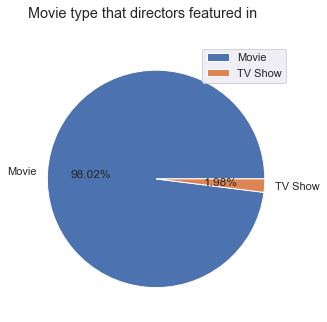

In [48]:
# Movie type that directors star in
type_df = pd.DataFrame(list_df['type'].value_counts())
ax = type_df.plot(kind='pie', legend=True, title='Movie type that directors featured in', 
                     subplots=True,autopct='%1.2f%%', figsize=(15,5), ylabel='')

plt.show()

Director tend to star in <code>movie</code> more than <code>TV show</code>

In [49]:
# List of top directors that are actors
list_director, count_director = np.unique(np.sum(list_df['director']),return_counts=True)

director_df = pd.DataFrame(data=list(zip(list_director, count_director)),columns=['Name','Movie_count'])\
                .sort_values(by=['Movie_count'], ascending=False)

number_director_cast = len(list_director)
number_all_director = len(np.unique(df_movies.loc[:,'director'].sum()))
print(f"There are {number_director_cast} on total of {number_all_director} have participated in acting in their own films,\
 equivalent to a rate of {np.round(number_director_cast / number_all_director *100,decimals=2)}%")

top_10_director = director_df.head(10).style.hide_index()

print(f'\nTop 10 directors participated in acting in their own movie, sort by movie count')
top_10_director

There are 273 on total of 3655 have participated in acting in their own films, equivalent to a rate of 7.47%

Top 10 directors participated in acting in their own movie, sort by movie count


Name,Movie_count
Yılmaz Erdoğan,6
Omoni Oboli,5
Robb Wells,5
John Paul Tremblay,5
Mike Smith,5
Cem Yılmaz,3
Ricky Gervais,3
Sylvester Stallone,3
Sermiyan Midyat,3
Louis C.K.,3


In [50]:
# Observe by movie type
director_by_type_list = list_df.explode('director').groupby(['director', 'type']).size().unstack(fill_value=0)
director_by_type_list = director_by_type_list.sort_values(by=['Movie'], ascending=False)

director_by_type_list.head(10)

type,Movie,TV Show
director,,
Yılmaz Erdoğan,6,0
Omoni Oboli,5,0
John Paul Tremblay,4,1
Mike Smith,4,1
Robb Wells,4,1
Note Chern-Yim,3,0
Sylvester Stallone,3,0
Cem Yılmaz,3,0
Sermiyan Midyat,3,0


<li>There are directors who work on both feature films and TV series, but they tend to produce more feature films, perhaps because theatrical releases generate higher revenue</li>
<li>Most directors are American, Canadian, England, Indonesian althoguh most movies original from American and Indian, account up to around 60% but not so many are both actors and directors</li>

## Question III: Create visualization illustrating the number of movies produced by each country over the years. Provide insight on the trends observed in film production.

The visualization will focus specifically on the top 10 countries that have produced the highest number of movies

In [51]:
# Exclude movies with no country info 
is_not_nan_list_country = df_movies['country'].apply(lambda x: True if x != ['nan'] else False)

# Count movie produced per country
list_country, count_country = np.unique(np.sum(df_movies.loc[is_not_nan_list_country,'country']),return_counts=True)

country_df = pd.DataFrame(data=list(zip(list_country, count_country)),columns=['Country','Movie_count'])\
                .sort_values(by=['Movie_count'], ascending=False)

# Top 10 countries produce the most movies
top_10_country = country_df.head(10)##.style.hide_index()

top_10_country

,Country,Movie_count
105,United States,2609
38,India,838
103,United Kingdom,601
14,Canada,318
29,France,271
45,Japan,231
91,Spain,178
89,South Korea,162
31,Germany,151
58,Mexico,129


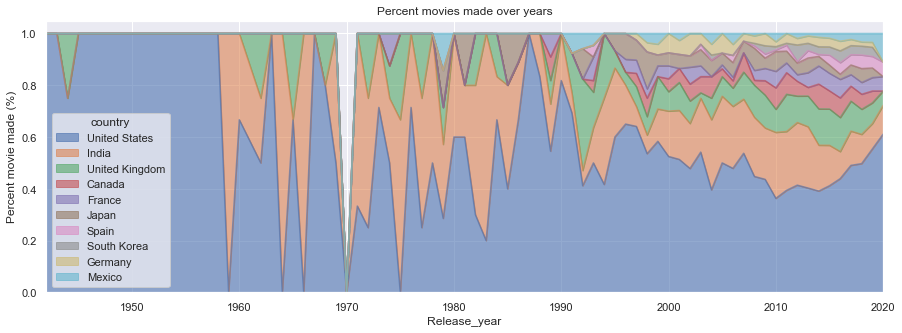

In [52]:
## Create data for chart
netflix_df_all = df_movies.loc[:,['country','release_year']].explode('country')\
                    .groupby(['release_year', 'country']).size().unstack(fill_value=0)\
                        .loc[:,top_10_country.loc[:,'Country']]
netflix_df_all = netflix_df_all.fillna(value=0).astype(np.int32)
perc_df = netflix_df_all.divide(netflix_df_all.sum(axis=1), axis=0)

## Import se
sns.set_theme()

## Create area plot
ax = perc_df.plot(kind='area', stacked=True, title='Percent movies made over years', 
                    figsize=(15,5), alpha=0.6, sharex=True )

## Set labels
ax.set_ylabel('Percent movie made (%)')
ax.set_xlabel('Release_year')
ax.margins(0, 0)

plt.show()

In [53]:
netflix_df_all.loc[[1970]]

country,United States,India,United Kingdom,Canada,France,Japan,Spain,South Korea,Germany,Mexico
release_year,,,,,,,,,,
1970,0,0,0,0,0,0,0,0,0,0


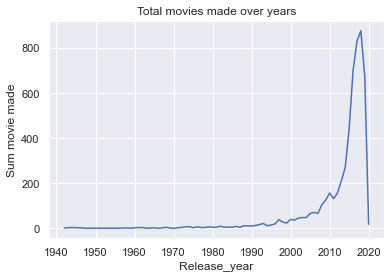

In [54]:
sum_movie = netflix_df_all.sum(axis=1)

# Create a line plot
plt.plot(sum_movie.index, sum_movie)

# Add labels and title
plt.xlabel('Release_year')
plt.ylabel('Sum movie made')
plt.title('Total movies made over years')

# Show the plot
plt.show()

Most movies were produced by The United States, following by Indian. These two alone take up to half of the movie produced
There is a no movie produced in 1970, caused a blank in the stacked chart. However this could be of coincidence that the dataset do not contain any movie produced in 1970, since the 70s was the era movie industry thrived.

Starting from the 80s, Asian market started to developed and produced more movies. However there is no China in the top 10 although the actual released movies from this country should be high. This could be affect by other elements such as politic, taste and country focus.

From the years of 2000s, the movie industry developed rapidly, an overwhelming number of new movies got released.

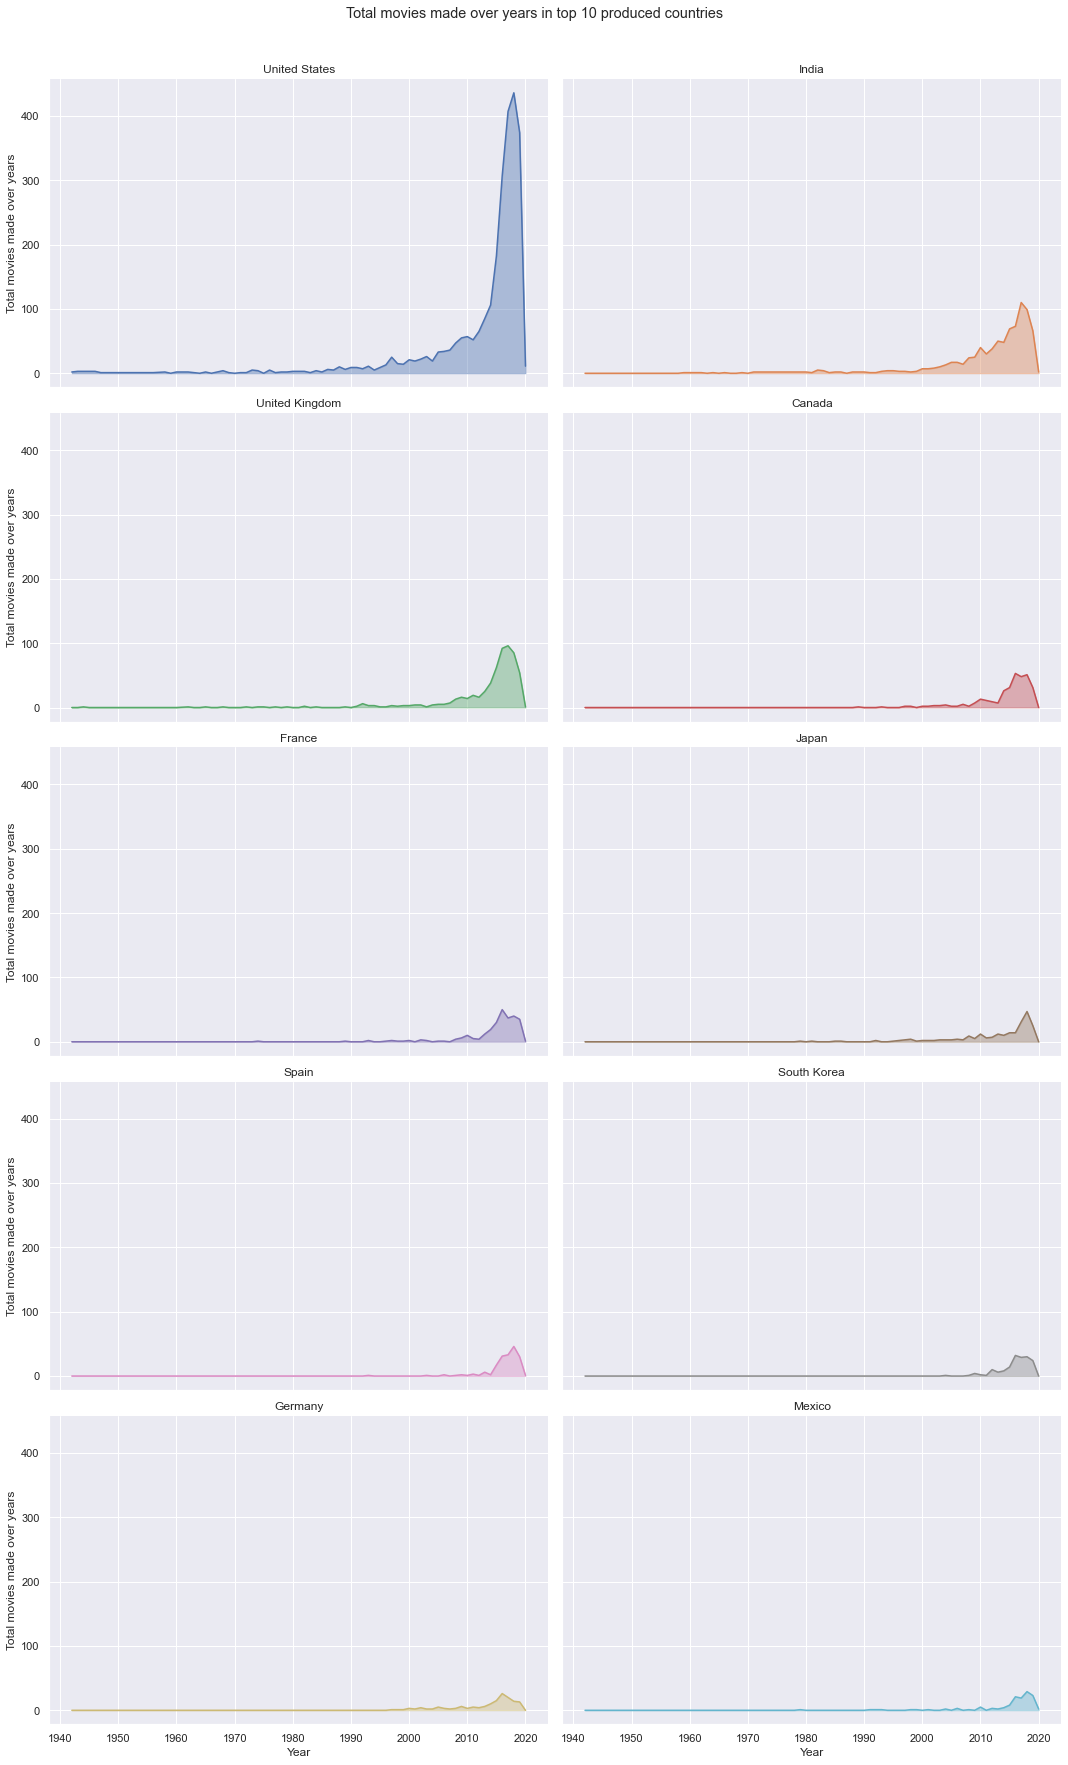

In [56]:
## Check on top 10 countries produced the most movies
netflix_df_stacked = pd.DataFrame(netflix_df_all.stack(0)).reset_index()
netflix_df_stacked.columns = ['Year','Country','Films']
netflix_df_stacked

# Create grid
gr = sns.FacetGrid(netflix_df_stacked, col='Country', hue='Country', col_wrap=2, height=5, aspect=1.5)

# Draw graph
gr = gr.map(plt.plot, 'Year', 'Films')

gr = gr.map(plt.fill_between, 'Year', 'Films', alpha=0.4)
 
# Labelling
gr = gr.set_titles("{col_name}")
gr = gr.set_ylabels("Total movies made over years")
gr = gr.set_xlabels("Year")

# Naming charts
plt.subplots_adjust(top=0.94)
gr = gr.fig.suptitle('Total movies made over years in top 10 produced countries')

plt.show()

Leave alone the year 2020 for incomplete data collecting, we can tell there is a trend across countries that is since 2010, movie industry started releasing more and more movies
Around 2019, number of movie produced slightly decrease, could be of the affect of pandemic
As Netflix main market is at the US, the high percent of added movies originally from the US could be to satisfy the customer's taste here